In this notebook we analyse the regret for each method proposed to solve policy control when rewards are delayed, aggregate and anonymous.

To measure regret, we use a policy learned with full reward information each time step.

The measure of comparison is the average return over all runs at the final episode $K_{max}$, $G_{avg,K_{max}} = \frac{1}{K_{max}}\sum^{K_{max}}_{K=1} G_{k}$.

Then we average that across runs, and compute the returns ratio as: $\frac{\mu_{\bar{G}^{m}_{K}} - \mu_{\bar{G}^{FR}_{K}}}{\vert \mu_{\bar{G}^{FR}_{K}} \rvert}$.
It tells us the percentage difference in average return between the policy trained with algorithm $m$ compared to the full rewards policy.
Lower is better.

Key on methods:

  - "PP/FR": Full rewards information
  - "PP/IMR": Impute missing rewards (zero when absent)
  - "PP/LEAST-LFA": Reward estimation
  - "OP-A/FR": Options policy, with composition actions as options
  - "OP-S/FR": Options policy, with repeated single action as options

In [1]:
import copy
import os
import pathlib
from typing import Set
import itertools

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats

In [3]:
from matplotlib import pyplot as plt


In [4]:
from drmdp import dataproc

In [5]:
import warnings # To suppress some warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [6]:
files = tf.io.gfile.glob(f"{pathlib.Path.home()}/fs/drmdp/workflows/controljob/agg/1762657758/1762661657/metrics/*.parquet")

In [7]:
df_metrics = dataproc.read_data(files, reader="pd")

In [8]:
df_metrics

,episode,exp_id,meta,returns,steps,metrics,method
1,970,1762657758-01d6cd78-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[118.16041560897803, 143.71843063334885, 135.0...","[8, 200, 200, 200, 200, 200, 200, 13, 200, 200...","{'returns': {'mean': 198.17493603281486, 'std'...",L-TDD[B]
3,970,1762657758-0370b55e-Finite-CC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[259.25682146850914, 367.4612810322214, 184.95...","[200, 200, 131, 200, 16, 200, 200, 200, 200, 2...","{'returns': {'mean': 289.1105609206313, 'std':...",DMR
4,970,1762657758-04ecde51-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[224.4714986741585, 224.04583454146083, 225.93...","[126, 35, 200, 60, 157, 200, 11, 74, 200, 134,...","{'returns': {'mean': 222.13877462455582, 'std'...",IMR
5,970,1762657758-066d8913-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[341.2621642656161, 337.7658842043623, 338.626...","[200, 200, 8, 200, 200, 200, 200, 200, 200, 20...","{'returns': {'mean': 242.7854323164925, 'std':...",L-TDD[B]
6,970,1762657758-06c10883-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[184.69451015892088, 281.75159980636465, 283.1...","[200, 200, 76, 200, 200, 9, 200, 200, 200, 200...","{'returns': {'mean': 220.06277518806917, 'std'...",IMR
...,...,...,...,...,...,...,...
245,140,1762657758-fa602890-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[165.89181794454763, 223.66613176872346, 223.9...","[7, 28, 11, 200, 42, 200, 9, 7, 17, 200, 200, ...","{'returns': {'mean': 205.08457654084037, 'std'...",L-TDD[B]
248,140,1762657758-fc4346e6-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[309.80407567262176, 321.80453200060964, 320.6...","[200, 200, 200, 9, 10, 200, 200, 8, 200, 200, ...","{'returns': {'mean': 176.50512344824205, 'std'...",L-TDD[B]
249,140,1762657758-fdf57b2d-Finite-CC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[49.18929038196695, 256.46113567497395, 54.971...","[35, 106, 35, 200, 40, 27, 27, 200, 13, 28, 19...","{'returns': {'mean': 141.16092701240328, 'std'...",DMR
250,140,1762657758-fe2afc3c-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[228.2304607806074, 362.162338278834, 365.6786...","[200, 200, 200, 200, 200, 200, 200, 200, 200, ...","{'returns': {'mean': 298.92145891431653, 'std'...",L-TDD[B]


In [9]:
df_metrics.iloc[0]["meta"]

{'context': {'dummy': 0},
 'exp_id': '1762657758-01d6cd78-Finite-SC-ShuntDc-v0',
 'instance_id': 3,
 'run_config': {'episodes_per_run': 1000,
  'log_episode_frequency': 10,
  'num_runs': 30,
  'output_dir': 'gs://mo-hendrix-ml-workflows-storage/drmdp/workflows/controljob/logs/1762657758/1762657758-01d6cd78-Finite-SC-ShuntDc-v0/run_3/bayes-least-lfa/91bc1f84',
  'use_seed': True},
 'env_spec': {'args': {'constraint_violation_reward': 0.0,
   'emit_state': False,
   'max_episode_steps': 200,
   'penalty_gamma': 1.0,
   'reward_fn': 'pos-enf'},
  'feats_spec': {'args': None, 'name': 'scale'},
  'name': 'Finite-SC-ShuntDc-v0'},
 'epochs': 1,
 'problem_spec': {'delay_config': {'args': {'lam': 8.0,
    'max_delay': None,
    'min_delay': 3.0},
   'name': 'clipped-poisson'},
  'epsilon': 0.2,
  'gamma': 0.99,
  'learning_rate_config': {'args': {'initial_lr': 0.01}, 'name': 'constant'},
  'policy_type': 'markovian',
  'reward_mapper': {'args': {'attempt_estimation_episode': None,
    'check_fa

In [10]:
df_metrics

,episode,exp_id,meta,returns,steps,metrics,method
1,970,1762657758-01d6cd78-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[118.16041560897803, 143.71843063334885, 135.0...","[8, 200, 200, 200, 200, 200, 200, 13, 200, 200...","{'returns': {'mean': 198.17493603281486, 'std'...",L-TDD[B]
3,970,1762657758-0370b55e-Finite-CC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[259.25682146850914, 367.4612810322214, 184.95...","[200, 200, 131, 200, 16, 200, 200, 200, 200, 2...","{'returns': {'mean': 289.1105609206313, 'std':...",DMR
4,970,1762657758-04ecde51-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[224.4714986741585, 224.04583454146083, 225.93...","[126, 35, 200, 60, 157, 200, 11, 74, 200, 134,...","{'returns': {'mean': 222.13877462455582, 'std'...",IMR
5,970,1762657758-066d8913-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[341.2621642656161, 337.7658842043623, 338.626...","[200, 200, 8, 200, 200, 200, 200, 200, 200, 20...","{'returns': {'mean': 242.7854323164925, 'std':...",L-TDD[B]
6,970,1762657758-06c10883-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[184.69451015892088, 281.75159980636465, 283.1...","[200, 200, 76, 200, 200, 9, 200, 200, 200, 200...","{'returns': {'mean': 220.06277518806917, 'std'...",IMR
...,...,...,...,...,...,...,...
245,140,1762657758-fa602890-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[165.89181794454763, 223.66613176872346, 223.9...","[7, 28, 11, 200, 42, 200, 9, 7, 17, 200, 200, ...","{'returns': {'mean': 205.08457654084037, 'std'...",L-TDD[B]
248,140,1762657758-fc4346e6-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[309.80407567262176, 321.80453200060964, 320.6...","[200, 200, 200, 9, 10, 200, 200, 8, 200, 200, ...","{'returns': {'mean': 176.50512344824205, 'std'...",L-TDD[B]
249,140,1762657758-fdf57b2d-Finite-CC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[49.18929038196695, 256.46113567497395, 54.971...","[35, 106, 35, 200, 40, 27, 27, 200, 13, 28, 19...","{'returns': {'mean': 141.16092701240328, 'std'...",DMR
250,140,1762657758-fe2afc3c-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[228.2304607806074, 362.162338278834, 365.6786...","[200, 200, 200, 200, 200, 200, 200, 200, 200, ...","{'returns': {'mean': 298.92145891431653, 'std'...",L-TDD[B]


In [11]:
envs = dataproc.get_distinct_envs(df_metrics)

In [12]:
envs

{'Finite-SC-ShuntDc-v0': {'constraint_violation_reward': 0.0,
  'emit_state': False,
  'max_episode_steps': 200,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-CC-PermExDc-v0': {'constraint_violation_reward': 0.0,
  'emit_state': False,
  'max_episode_steps': 200,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-SC-PermExDc-v0': {'constraint_violation_reward': 0.0,
  'emit_state': False,
  'max_episode_steps': 200,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-TC-ShuntDc-v0': {'constraint_violation_reward': 0.0,
  'emit_state': False,
  'max_episode_steps': 200,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-TC-PermExDc-v0': {'constraint_violation_reward': 0.0,
  'emit_state': False,
  'max_episode_steps': 200,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-CC-ShuntDc-v0': {'constraint_violation_reward': 0.0,
  'emit_state': False,
  'max_episode_steps': 200,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'}}

In [13]:
METHODS = sorted(df_metrics["method"].unique())

In [14]:
METHODS

['DMR', 'FR', 'IMR', 'L-TDD[B]', 'OP-A']

In [15]:
def parse_delay_config(df_input: pd.DataFrame):
    df = copy.deepcopy(df_input)
    def parse_mu(delay_config):
        if delay_config is None:
            return None
        args = delay_config["args"]
        try:
            return args["delay"]
        except KeyError:
            return args["lam"]
        except KeyError as exc:
            raise ValueError(f"Unknown delay config {args}") from exc
    df["delay_type"] = df["delay_config"].apply(lambda dc: dc["name"] if dc else None)
    df["delay_mu"] = df["delay_config"].apply(parse_mu)
    del df["delay_config"]
    return df

In [16]:
def max_episode_filter(df_input):
    env_spec = df_input["meta"].apply(lambda meta: meta["env_spec"])
    env_name = env_spec.apply(lambda spec: spec["name"])
    envs = env_name.unique()
    dfs = []
    for env in envs:
        df_slice = df_input[
            (env_name == env)
        ]
        df_slice = df_slice[df_slice["episode"] == df_slice["episode"].max()]
        dfs.append(
            copy.deepcopy(df_slice)
        )
    return pd.concat(dfs)
    

In [17]:
def extract_salient_meta_fields(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(df_data)
    
    specs = {
        "env": df_raw["meta"].apply(lambda meta: meta["env_spec"]),
        "feats": df_raw["meta"].apply(lambda meta: meta["env_spec"]["feats_spec"])
    }
    
    for prefix, col_fam in specs.items():
        for col in ("name", "args"):
            df_raw[f"{prefix}_{col}"] = col_fam.apply(lambda spec: spec[col])

    for key in ("delay_config", "gamma",):
        df_raw[key] = df_raw["meta"].apply(lambda meta: meta["problem_spec"][key])    
    return parse_delay_config(df_raw)

## Regret - Relative to full rewards observation

In [18]:
def calculate_regret_over_configurations(
    df_data
):    
    def calc_regret(y_pred, y_oracle):
        # agg returns
        mean_y_oracle = np.mean(y_oracle)
        return (np.mean(y_pred) - mean_y_oracle) / np.abs(mean_y_oracle)
    
    df_result = max_episode_filter(df_data)
    df_result = extract_salient_meta_fields(df_result) 

    df_baseline = df_result[pd.isnull(df_result["delay_type"])]
    df_result = df_result[~pd.isnull(df_result["delay_type"])]
    
    baselines = {}
    keys = ["env_name", "gamma", "delay_config"]
    for row in df_baseline.to_dict("records"):
        key = tuple(row[key] for key in keys[:-1])
        baselines[key] = row["returns"]

    for key in sorted(baselines.keys()):
        print(key)

    rows = []
    for row in df_result.to_dict("records"):
        key = tuple([row[key] for key in keys[:-1]])
        full_reward_mean_return = baselines[key]
        regret = calc_regret(y_pred=row["returns"], y_oracle = full_reward_mean_return)
        row["relative_regret"] = regret
        row["method"] = row["method"]
        rows.append(row)

    df_regret = pd.DataFrame(rows)
    df_regret = df_regret[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]].sort_values(
        ["env_name", "method", "delay_type", "delay_mu"]
    )
    return {"sarsa": df_regret}

In [19]:
METHODS_PALETTES = {
    key: palette for key, palette in zip(
        ["FR", "DMR", "IMR", "LEAST", "L-TDD", "L-TDD[B]", "L-TDD[CV]", "L-TDD[CV-R]", "OP-A", "OP-S"],
        sns.color_palette()
    )
}

In [20]:
METHODS_PALETTES

{'FR': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'DMR': (1.0, 0.4980392156862745, 0.054901960784313725),
 'IMR': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'LEAST': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'L-TDD': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'L-TDD[B]': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'L-TDD[CV]': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'L-TDD[CV-R]': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'OP-A': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'OP-S': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)}

In [21]:
def plot_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/regret"):
    df_raw = copy.deepcopy(df_data[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]])
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]
    rps = sorted(df_raw["delay_mu"].unique())
    
    fig, axes = plt.subplots(
        nrows=1, ncols=len(rps), figsize=(4 * len(rps), 4), 
        sharey=False,
    )
    
    legend_shown = False
    for ax, rp in zip(axes.flatten(), rps):
        df_plot = df_raw[df_raw["delay_mu"] == rp]
        sns.boxplot(
            df_plot, 
            x="env_name", y="relative_regret", 
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_title(f"Reward Delay, P = {rp}")
        if legend_shown is False:
            legend_shown = True
            ax.set_ylabel("Returns Ratio")
            ax.legend(loc='upper center', bbox_to_anchor=(len(rps) / 2.0, 1.3), ncol=3, fancybox=True)
        else:
            ax.set(ylabel=None)
            ax.legend().set_visible(False)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    name = f"regret_{suffix}.pdf"        
    path = os.path.join(output_dir, name)
    plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")  

In [22]:
dfs_regret = calculate_regret_over_configurations(df_metrics)

('Finite-CC-PermExDc-v0', 0.99)
('Finite-CC-PermExDc-v0', 1.0)
('Finite-CC-ShuntDc-v0', 0.99)
('Finite-CC-ShuntDc-v0', 1.0)
('Finite-SC-PermExDc-v0', 0.99)
('Finite-SC-PermExDc-v0', 1.0)
('Finite-SC-ShuntDc-v0', 0.99)
('Finite-SC-ShuntDc-v0', 1.0)
('Finite-TC-PermExDc-v0', 0.99)
('Finite-TC-PermExDc-v0', 1.0)
('Finite-TC-ShuntDc-v0', 0.99)
('Finite-TC-ShuntDc-v0', 1.0)


In [23]:
dfs_regret["sarsa"]

,env_name,method,delay_type,delay_mu,relative_regret
37,Finite-CC-PermExDc-v0,DMR,clipped-poisson,2.0,-0.018042
46,Finite-CC-PermExDc-v0,DMR,clipped-poisson,2.0,-0.021263
32,Finite-CC-PermExDc-v0,DMR,clipped-poisson,4.0,-0.022009
39,Finite-CC-PermExDc-v0,DMR,clipped-poisson,4.0,-0.140878
28,Finite-CC-PermExDc-v0,DMR,clipped-poisson,6.0,-0.095762
...,...,...,...,...,...
103,Finite-TC-ShuntDc-v0,L-TDD[B],clipped-poisson,8.0,-0.095800
106,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,2.0,-0.598071
108,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,2.0,-0.633922
87,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,4.0,-0.473411


In [24]:
dfs_regret["sarsa"]["env_name"].unique()

array(['Finite-CC-PermExDc-v0', 'Finite-CC-ShuntDc-v0',
       'Finite-SC-PermExDc-v0', 'Finite-SC-ShuntDc-v0',
       'Finite-TC-PermExDc-v0', 'Finite-TC-ShuntDc-v0'], dtype=object)

In [25]:
sorted(dfs_regret["sarsa"]["delay_mu"].unique())

[2.0, 4.0, 6.0, 8.0]

In [26]:
dfs_regret["sarsa"].dtypes

env_name            object
method              object
delay_type          object
delay_mu           float64
relative_regret    float64
dtype: object

In [27]:
def filter_envs(df_input, envs: Set[str]):
    mask = df_input["env_name"].apply(
        lambda name: name in envs
    )
    return copy.copy(df_input[mask])

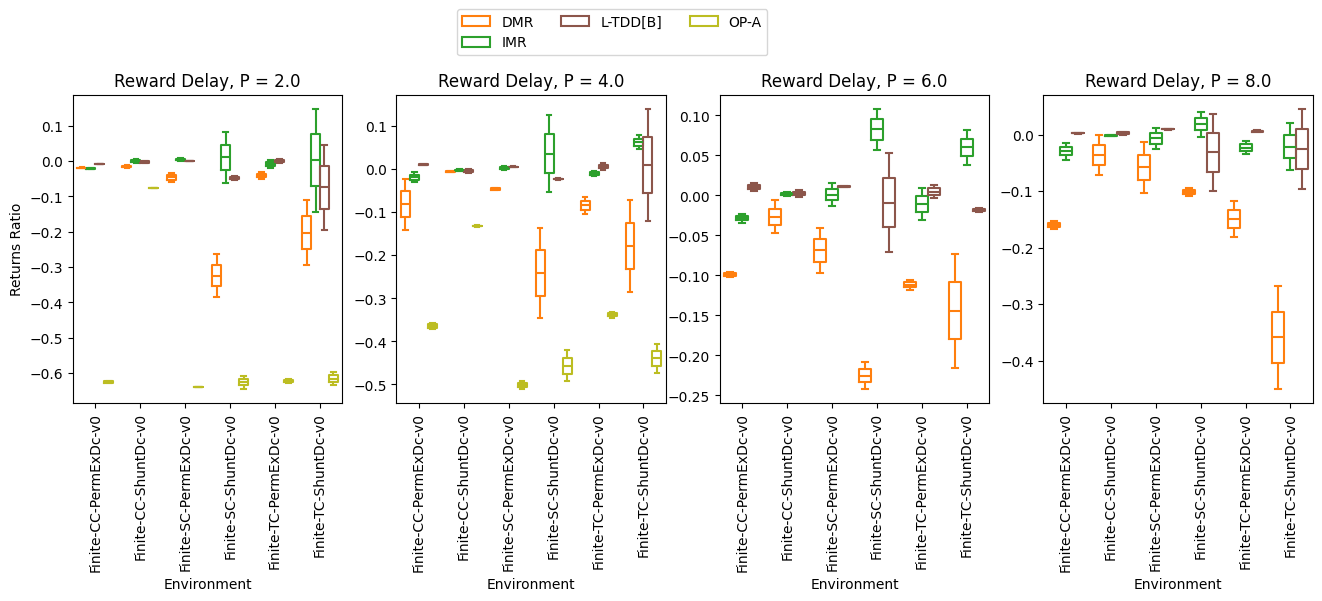

In [28]:
plot_regret(dfs_regret["sarsa"], suffix="sarsa")

## Proc Data: Run Return Matrix

For the next metrics, we need a matrix where each run is is a row, and the columns represent returns at each episode.

In [29]:
def calc_runs_returns_matrix(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(df_data[["episode", "exp_id", "returns", "steps", "meta", "method"]])

    rows = []
    experiments = df_metrics["exp_id"].unique()
    for exp_id in experiments:
        df_exp = df_raw[df_raw["exp_id"] == exp_id]
        example = df_exp.iloc[0]
        # get episodes time series
        episodes = np.array(df_exp["episode"].values)
        # matrix of return (rows) x run (columns)
        returns = np.stack(df_exp["returns"].values)
        steps = np.stack(df_exp["steps"].values)
        # sort episodes
        sorting_indices = np.argsort(episodes)
        # reorder returns by episode - earliest to latest
        sorted_returns = returns[sorting_indices, :]
        sorted_steps = steps[sorting_indices, :]
        # transpose matrix to run (rows) x return (columns)
        runs_returns_matrix = np.transpose(sorted_returns)
        runs_steps_matrix = np.transpose(sorted_steps)
        rows.append(
            {
                "exp_id": exp_id,
                "runs_returns_matrix": runs_returns_matrix,
                "runs_steps_matrix": runs_steps_matrix,
                "env_name": example["meta"]["env_spec"]["name"],
                "gamma": example["meta"]["problem_spec"]["gamma"],
                "delay_config": example["meta"]["problem_spec"]["delay_config"],
                "method": example["method"],
                "meta": example["meta"],
                "episodes": np.array(sorted(episodes))
            }
        )
    return parse_delay_config(pd.DataFrame(rows))   

In [30]:
%%time
df_runs_returns = calc_runs_returns_matrix(df_metrics)

CPU times: user 290 ms, sys: 6.28 ms, total: 296 ms
Wall time: 178 ms


In [31]:
df_runs_returns

,exp_id,runs_returns_matrix,runs_steps_matrix,env_name,gamma,method,meta,episodes,delay_type,delay_mu
0,1762657758-01d6cd78-Finite-SC-ShuntDc-v0,"[[44.911918722985206, 17.976703960823784, 14.3...","[[24, 8, 8, 7, 8, 9, 12, 10, 9, 13, 13, 8, 8, ...",Finite-SC-ShuntDc-v0,0.99,L-TDD[B],"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0
1,1762657758-0370b55e-Finite-CC-PermExDc-v0,"[[29.07468054917261, 25.240747956329486, 355.7...","[[16, 11, 200, 16, 200, 12, 23, 31, 47, 12, 12...",Finite-CC-PermExDc-v0,0.99,DMR,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0
2,1762657758-04ecde51-Finite-SC-PermExDc-v0,"[[364.3515201309854, 345.89390866003043, 221.4...","[[200, 200, 200, 13, 49, 8, 189, 20, 38, 200, ...",Finite-SC-PermExDc-v0,0.99,IMR,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0
3,1762657758-066d8913-Finite-TC-ShuntDc-v0,"[[53.28262543289976, 378.59847142215136, 379.4...","[[29, 200, 200, 7, 200, 200, 200, 200, 200, 20...",Finite-TC-ShuntDc-v0,1.00,L-TDD[B],"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0
4,1762657758-06c10883-Finite-SC-ShuntDc-v0,"[[290.18245501860576, 321.97365267502727, 317....","[[200, 200, 175, 200, 200, 200, 9, 200, 11, 20...",Finite-SC-ShuntDc-v0,0.99,IMR,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0
...,...,...,...,...,...,...,...,...,...,...
175,1762657758-fa602890-Finite-SC-PermExDc-v0,"[[392.5324517998436, 193.14672567555618, 230.4...","[[200, 8, 11, 78, 8, 200, 200, 200, 11, 200, 1...",Finite-SC-PermExDc-v0,0.99,L-TDD[B],"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0
176,1762657758-fc4346e6-Finite-SC-ShuntDc-v0,"[[43.558060003561465, 233.6681008087724, 258.6...","[[30, 200, 163, 200, 200, 200, 200, 200, 200, ...",Finite-SC-ShuntDc-v0,0.99,L-TDD[B],"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0
177,1762657758-fdf57b2d-Finite-CC-PermExDc-v0,"[[275.0446717261737, 179.9030584944205, 141.43...","[[178, 200, 14, 114, 39, 63, 31, 132, 200, 77,...",Finite-CC-PermExDc-v0,0.99,DMR,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0
178,1762657758-fe2afc3c-Finite-TC-PermExDc-v0,"[[71.00904472450819, 211.3157090217242, 88.954...","[[40, 200, 200, 200, 200, 200, 200, 200, 200, ...",Finite-TC-PermExDc-v0,1.00,L-TDD[B],"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0


In [32]:
np.stack(df_runs_returns.iloc[0]["runs_returns_matrix"])

array([[ 44.91191872,  17.97670396,  14.35079659, ..., 118.16041561,
        119.50642565, 142.65461491],
       [ 31.02282888,  16.05950978,  16.31610668, ..., 143.71843063,
        139.88867763, 121.07541055],
       [ 41.73800667,  20.34733184,  17.46441004, ..., 135.02987488,
        136.02690116, 137.22410264],
       ...,
       [397.30424211,  13.88009678, 336.67754172, ..., 282.63550985,
        282.01398589, 284.1060607 ],
       [348.80474695, 270.75936633, 308.84323272, ..., 147.40454465,
        284.10396752, 284.71321244],
       [ 22.25057902, 305.11685024, 307.71997183, ..., 285.49993184,
        284.56298581, 121.9680325 ]])

In [33]:
np.stack(df_runs_returns.iloc[0]["runs_steps_matrix"])

array([[ 24,   8,   8, ...,   8, 200, 200],
       [ 16,   7,   9, ..., 200, 200,   9],
       [ 27,   7,   9, ..., 200, 200, 200],
       ...,
       [200,   8, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       [ 16, 200, 200, ...,   9, 200, 200]])

In [34]:
def calc_ci(xs, confidence: float, method: str = "auto"):
    if method not in ("auto", "t-distribution", "normal"):
        raise ValueError("Method must be one of: {auto, t-distribution, normal}")

    # calculate mean 
    mean = np.mean(xs)
    # standard error
    std_err = stats.sem(xs)

    if (method == "auto" and len(xs) < 30) or method == "t-distribution":
        form = "t-distribution"
        lb, ub = stats.t.interval(confidence=confidence, df=len(xs)-1, loc=mean, scale=std_err)
    else:
        form = "normal"
        lb, ub = stats.norm.interval(confidence=confidence, loc=mean, scale=std_err)

    ci = np.abs(ub - mean)
    return {"ub": ub, "lb": lb, "mean": mean, "ci": ci, "ci_method": form}

In [35]:
def calc_and_format_ci(xs, confidence: float, decimals: int):
    xs = xs[~np.isnan(xs)]
    if len(xs) == 0:
        xs = [np.nan]
    ci_result = calc_ci(xs, confidence=confidence, method="auto")
    ci_fmt = " ± ".join([
        str(np.around(ci_result["mean"], decimals)),
        str(np.around(ci_result["ci"], decimals)),
    ])
    return ci_result, ci_fmt

In [36]:
def calc_env_method_returns_ci(df_results: pd.DataFrame, confidence: float, decimals: int = 4) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    envs = sorted(df_results["env_name"].unique())
    methods = sorted(df_results["method"].unique())
    
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = copy.copy(
            df_results[
                (df_results["env_name"] == env) &
                (df_results["method"] == method)
            ]
        )
        
        # across delays, gamma, and runs
        # shape: config x run x episodes
        returns_matrix = np.stack(df_slice["runs_returns_matrix"].values)
        # take last episode
        returns_matrix = returns_matrix[:,:,-1]
        returns = returns_matrix.flatten()
        ci_result, ci_fmt = calc_and_format_ci(returns, confidence=confidence, decimals=decimals)
        row = {
            "env_name": env,
            "method": method,
            "ci_fmt": ci_fmt,
            **ci_result
        }
        rows.append(row)
    return pd.DataFrame(rows).sort_values(["env_name", "method"])

In [37]:
calc_env_method_returns_ci(df_runs_returns, confidence=0.95).pivot(columns="method", index="env_name", values="ci_fmt")    

method,DMR,FR,IMR,L-TDD[B],OP-A
env_name,,,,,
Finite-CC-PermExDc-v0,288.8082 ± 7.525,317.3494 ± 5.1851,309.5176 ± 3.1457,318.4249 ± 3.0696,160.232 ± 7.7
Finite-CC-ShuntDc-v0,362.7947 ± 4.4919,370.5621 ± 1.6613,370.3301 ± 0.6926,370.4117 ± 0.7083,331.9566 ± 2.03
Finite-SC-PermExDc-v0,210.0286 ± 3.2381,222.2377 ± 1.6193,222.2747 ± 0.6398,223.6908 ± 0.6899,95.4413 ± 3.2883
Finite-SC-ShuntDc-v0,166.8632 ± 19.0356,214.7425 ± 19.4691,222.2804 ± 9.0306,208.45 ± 9.5355,98.2829 ± 3.5329
Finite-TC-PermExDc-v0,287.2107 ± 7.0492,318.0159 ± 3.1179,313.8332 ± 1.8145,319.3121 ± 1.7042,165.2923 ± 8.3781
Finite-TC-ShuntDc-v0,187.0286 ± 21.9876,240.1826 ± 23.9632,246.096 ± 9.8779,233.1551 ± 12.3731,113.2362 ± 4.0535


In [38]:
print(calc_env_method_returns_ci(
    df_runs_returns[
        df_runs_returns["method"].apply(
            lambda met: met not in set(["FR"])
        )
    ],
    confidence=0.95
).pivot(columns="method", index="env_name", values="ci_fmt").to_latex())

\begin{tabular}{lllll}
\toprule
method & DMR & IMR & L-TDD[B] & OP-A \\
env_name &  &  &  &  \\
\midrule
Finite-CC-PermExDc-v0 & 288.8082 ± 7.525 & 309.5176 ± 3.1457 & 318.4249 ± 3.0696 & 160.232 ± 7.7 \\
Finite-CC-ShuntDc-v0 & 362.7947 ± 4.4919 & 370.3301 ± 0.6926 & 370.4117 ± 0.7083 & 331.9566 ± 2.03 \\
Finite-SC-PermExDc-v0 & 210.0286 ± 3.2381 & 222.2747 ± 0.6398 & 223.6908 ± 0.6899 & 95.4413 ± 3.2883 \\
Finite-SC-ShuntDc-v0 & 166.8632 ± 19.0356 & 222.2804 ± 9.0306 & 208.45 ± 9.5355 & 98.2829 ± 3.5329 \\
Finite-TC-PermExDc-v0 & 287.2107 ± 7.0492 & 313.8332 ± 1.8145 & 319.3121 ± 1.7042 & 165.2923 ± 8.3781 \\
Finite-TC-ShuntDc-v0 & 187.0286 ± 21.9876 & 246.096 ± 9.8779 & 233.1551 ± 12.3731 & 113.2362 ± 4.0535 \\
\bottomrule
\end{tabular}



## Returns AUC

In [39]:
def calc_returns_auc(df_data: pd.DataFrame):
    def calc_auc(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        timesteps = np.arange(runs_returns_matrix.shape[1])
        return np.trapz(runs_returns_matrix, x=timesteps, axis=1)

    df_raw = copy.deepcopy(df_data[["exp_id", "runs_returns_matrix", "meta", "method"]])
    df_raw["auc"] = df_raw["runs_returns_matrix"].apply(calc_auc)
    df_raw = extract_salient_meta_fields(df_raw)
    del df_raw["runs_returns_matrix"]
    del df_raw["meta"]
    return df_raw

In [40]:
df_returns_auc = calc_returns_auc(df_runs_returns)

In [41]:
df_returns_auc

,exp_id,method,auc,env_name,env_args,feats_name,feats_args,gamma,delay_type,delay_mu
0,1762657758-01d6cd78-Finite-SC-ShuntDc-v0,L-TDD[B],"[4657.457896448167, 4771.608513654376, 4614.60...",Finite-SC-ShuntDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",scale,None,0.99,clipped-poisson,8.0
1,1762657758-0370b55e-Finite-CC-PermExDc-v0,DMR,"[21652.051658771477, 21056.82919583041, 20110....",Finite-CC-PermExDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",spliced-tiles,{'tiling_dim': 4.0},0.99,clipped-poisson,6.0
2,1762657758-04ecde51-Finite-SC-PermExDc-v0,IMR,"[22469.74208037776, 22449.837345591346, 21937....",Finite-SC-PermExDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",spliced-tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,2.0
3,1762657758-066d8913-Finite-TC-ShuntDc-v0,L-TDD[B],"[24377.213335398195, 23953.81624053778, 24162....",Finite-TC-ShuntDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",scale,None,1.00,clipped-poisson,8.0
4,1762657758-06c10883-Finite-SC-ShuntDc-v0,IMR,"[23080.371411339776, 24622.728271336644, 23478...",Finite-SC-ShuntDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",scale,None,0.99,clipped-poisson,8.0
...,...,...,...,...,...,...,...,...,...,...
175,1762657758-fa602890-Finite-SC-PermExDc-v0,L-TDD[B],"[21020.682999830256, 20770.33900392987, 20892....",Finite-SC-PermExDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",spliced-tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,8.0
176,1762657758-fc4346e6-Finite-SC-ShuntDc-v0,L-TDD[B],"[28860.327950292824, 17421.489685646186, 18301...",Finite-SC-ShuntDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",scale,None,0.99,clipped-poisson,4.0
177,1762657758-fdf57b2d-Finite-CC-PermExDc-v0,DMR,"[20236.173101111784, 20213.207768768738, 17835...",Finite-CC-PermExDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",spliced-tiles,{'tiling_dim': 4.0},0.99,clipped-poisson,8.0
178,1762657758-fe2afc3c-Finite-TC-PermExDc-v0,L-TDD[B],"[31576.07013190417, 31097.70620068484, 31557.7...",Finite-TC-PermExDc-v0,"{'constraint_violation_reward': 0.0, 'emit_sta...",tiles,{'tiling_dim': 3.0},1.00,clipped-poisson,4.0


In [42]:
def plot_auc(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(df_data)
    df_metric = df_raw.explode("auc")
    df_metric = df_metric[~pd.isnull(df_metric["delay_mu"])]
    
    delays = sorted(df_metric["delay_mu"].unique())
    fig, axes = plt.subplots(
        nrows=1, ncols=len(delays), figsize=(4 * len(delays), 4), 
        sharey=False,
    )
    
    legend_shown = False
    for ax, delay in zip(axes.flatten(), delays):
        df_plot = df_metric[df_metric["delay_mu"] == delay]
        sns.boxplot(
            df_plot, 
            x="env_name", y="auc", 
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_title(f"Reward Delay, P = {delay}")
        if legend_shown is False:
            legend_shown = True
            ax.set_ylabel("Returns AUC")
            ax.legend(loc='upper center', bbox_to_anchor=(len(delays) / 2.0, 1.3), ncol=3, fancybox=True)
        else:
            ax.set(ylabel=None)
            ax.legend().set_visible(False)    

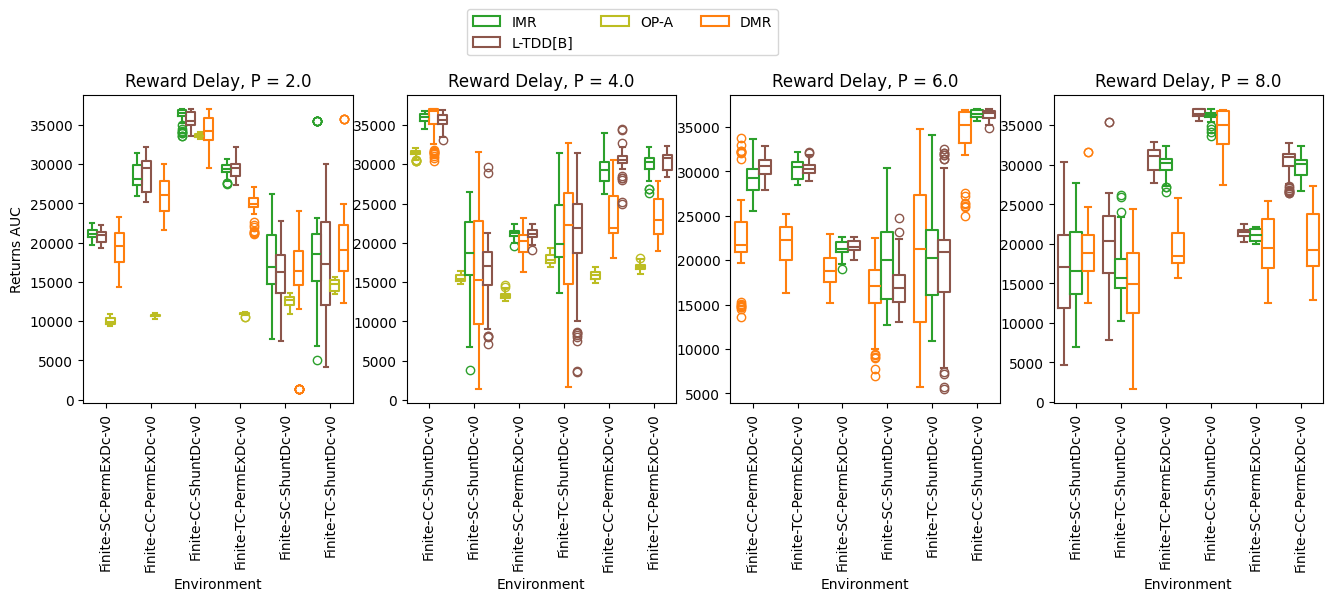

In [43]:
plot_auc(df_returns_auc)

## Time to Threshold Returns

In [44]:
def calc_time_in_threshold_last_quartile(df_data, threshold: float = 0.9):
    fr_mask = df_data["method"] == "FR"
    df_fr = df_data[fr_mask]
    df_other = df_data[~fr_mask]

    rows = []
    # each row is a config: env x gamma x method x delay
    for row in df_other.to_dict("records"):
        # get baseline returns
        df_fr_slice = df_fr[
            (
                df_fr["env_name"] == row["env_name"]
            ) & (
                df_fr["gamma"] == row["gamma"]
            )
        ]
        fr_returns_matrix = np.stack(df_fr_slice.iloc[0]["runs_returns_matrix"])
        # across episodes
        fr_mean_returns = np.mean(fr_returns_matrix)
        
        method_returns_matrix = np.stack(row["runs_returns_matrix"])
        # approx time spent within range of threshold
        # runs x episodes
        entry = copy.deepcopy(row)
        if fr_mean_returns > 0:
            bound = threshold * fr_mean_returns
        else:
            bound = (2 - threshold) * fr_mean_returns
        
        entry["time_above_threshold"] = np.mean(
                np.sum(
                    # use abs for negative returns
                    # TODO: check if pos or negative; differen top
                    method_returns_matrix >= bound, axis=1
                ) / method_returns_matrix.shape[1]
            )
        rows.append(entry)
    return pd.DataFrame(rows)

In [45]:
def calc_env_method_return_perctile_ci(df_results: pd.DataFrame, confidence: float, decimals: int = 4) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    envs = sorted(df_results["env_name"].unique())
    methods = sorted(df_results["method"].unique())
    
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = copy.copy(
            df_results[
                (df_results["env_name"] == env) &
                (df_results["method"] == method)
            ]
        )
        
        # across delays, gamma, and runs
        values = df_slice["time_above_threshold"].values
        ci_result, ci_fmt = calc_and_format_ci(values, confidence=confidence, decimals=decimals)
        row = {
            "env_name": env,
            "method": method,
            "ci_fmt": ci_fmt,
            **ci_result
        }
        rows.append(row)
    return pd.DataFrame(rows).sort_values(["env_name", "method"])

In [46]:
df_time_in_threshold = calc_time_in_threshold_last_quartile(df_runs_returns)

In [47]:
df_time_in_threshold.head()

,exp_id,runs_returns_matrix,runs_steps_matrix,env_name,gamma,method,meta,episodes,delay_type,delay_mu,time_above_threshold
0,1762657758-01d6cd78-Finite-SC-ShuntDc-v0,"[[44.911918722985206, 17.976703960823784, 14.3...","[[24, 8, 8, 7, 8, 9, 12, 10, 9, 13, 13, 8, 8, ...",Finite-SC-ShuntDc-v0,0.99,L-TDD[B],"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0,0.432667
1,1762657758-0370b55e-Finite-CC-PermExDc-v0,"[[29.07468054917261, 25.240747956329486, 355.7...","[[16, 11, 200, 16, 200, 12, 23, 31, 47, 12, 12...",Finite-CC-PermExDc-v0,0.99,DMR,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0,0.409000
2,1762657758-04ecde51-Finite-SC-PermExDc-v0,"[[364.3515201309854, 345.89390866003043, 221.4...","[[200, 200, 200, 13, 49, 8, 189, 20, 38, 200, ...",Finite-SC-PermExDc-v0,0.99,IMR,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0,0.910000
3,1762657758-066d8913-Finite-TC-ShuntDc-v0,"[[53.28262543289976, 378.59847142215136, 379.4...","[[29, 200, 200, 7, 200, 200, 200, 200, 200, 20...",Finite-TC-ShuntDc-v0,1.00,L-TDD[B],"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0,0.533000
4,1762657758-06c10883-Finite-SC-ShuntDc-v0,"[[290.18245501860576, 321.97365267502727, 317....","[[200, 200, 175, 200, 200, 200, 9, 200, 11, 20...",Finite-SC-ShuntDc-v0,0.99,IMR,"{'context': {'dummy': 0}, 'exp_id': '176265775...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0,0.542000


In [48]:
calc_env_method_return_perctile_ci(
    df_time_in_threshold,
    confidence=0.95
).pivot(columns="method", index="env_name", values="ci_fmt")        


/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


method,DMR,IMR,L-TDD[B],OP-A
env_name,,,,
Finite-CC-PermExDc-v0,0.4323 ± 0.1057,0.7643 ± 0.0216,0.8191 ± 0.0212,0.0 ± nan
Finite-CC-ShuntDc-v0,0.8764 ± 0.0566,0.9545 ± 0.0169,0.9442 ± 0.0267,0.5237 ± 0.7208
Finite-SC-PermExDc-v0,0.6654 ± 0.0823,0.9261 ± 0.0197,0.9092 ± 0.0203,0.0753 ± 0.0307
Finite-SC-ShuntDc-v0,0.508 ± 0.0644,0.5515 ± 0.0519,0.4683 ± 0.0451,0.2809 ± 0.2535
Finite-TC-PermExDc-v0,0.417 ± 0.1251,0.8625 ± 0.0151,0.876 ± 0.0153,0.0 ± nan
Finite-TC-ShuntDc-v0,0.4917 ± 0.0839,0.4875 ± 0.0906,0.4916 ± 0.0784,0.2827 ± 0.2121


Most of these environments have high variance in their starts, or get worse before they get good.
Measuring time to reach a threshold result is unreliable.

## Method Efficiency per Delay

In [49]:
def plot_delay_perf_curves(df_data, metric: str):
    df_raw = df_data[["env_name", "gamma", "delay_mu", "method", metric]]
    df_raw = copy.deepcopy(df_raw[df_raw["method"] != "FR"])
    palette = {key: pl for key, pl in METHODS_PALETTES.items() if key != "FR"}
    envs = sorted(df_raw["env_name"].unique())
    ncols = len(envs)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4*ncols, 4))

    for env, ax in zip(envs, axes.flatten()):
        df_slice = df_raw[df_raw["env_name"] == env]
        sns.lineplot(
            data=df_slice,
            x="delay_mu", y=metric, hue="method", style="method",
            palette=palette,
            markers=True, dashes=False,
            ax=ax
        )
        ax.set_title(env)

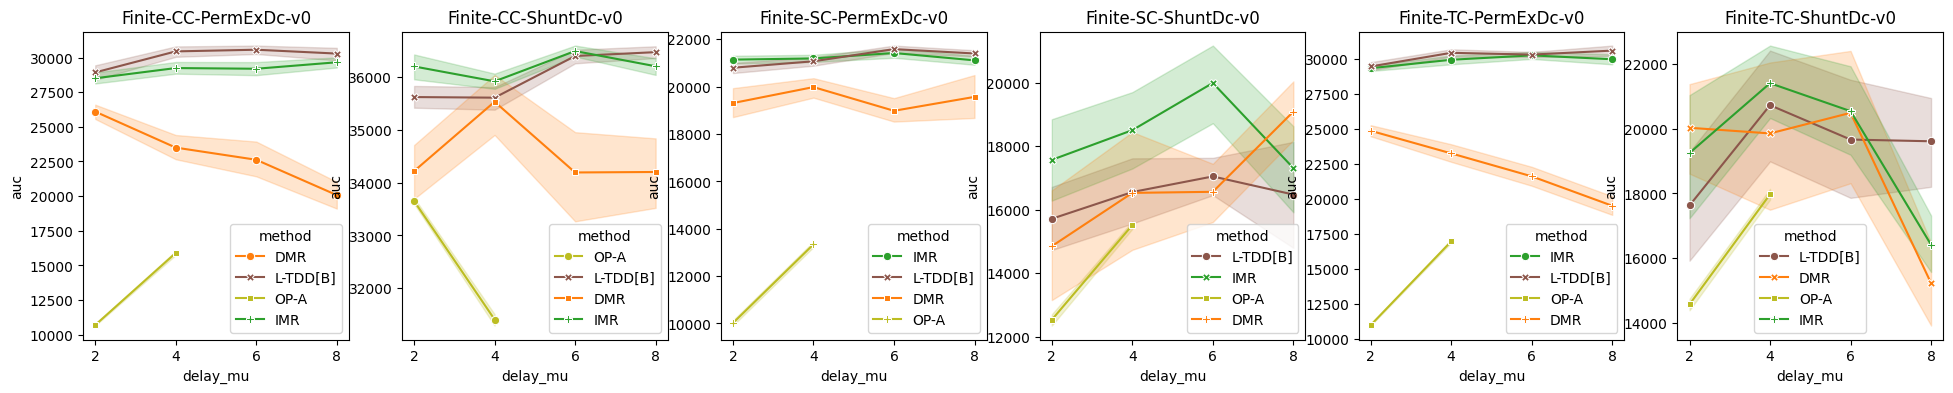

In [50]:
plot_delay_perf_curves(df_returns_auc.explode("auc").reset_index(), metric="auc")

## Returns Interquartile Mean @ K (IQM@K)

In [51]:
def calc_returns_iqm(df_data, confidence: float, decimals: int = 4):
    def calc_iqm_returns(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        runs_returns = runs_returns_matrix[:,-1]
        return stats.trimboth(runs_returns, proportiontocut=0.25)

    df_raw = copy.deepcopy(df_data)
    df_raw["iqm_returns"] = df_raw["runs_returns_matrix"].apply(calc_iqm_returns)

    envs = sorted(df_raw["env_name"].unique())
    methods = sorted(df_raw["method"].unique())
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = df_raw[
            (
                df_raw["env_name"] == env
            ) & (
                df_raw["method"] == method
            )
        ]
        # across delays, gamma, and runs
        values = np.stack(df_slice["iqm_returns"]).flatten()
        ci_result, ci_fmt = calc_and_format_ci(values, confidence=confidence, decimals=decimals)
        row = {
            "env_name": env,
            "method": method,
            "ci_fmt": ci_fmt,
            **ci_result
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

In [52]:
calc_returns_iqm(df_runs_returns, confidence=0.95).pivot(columns="method", index="env_name", values="ci_fmt")

method,DMR,FR,IMR,L-TDD[B],OP-A
env_name,,,,,
Finite-CC-PermExDc-v0,286.9984 ± 6.4059,318.1164 ± 3.6221,310.9025 ± 2.6899,322.272 ± 2.2374,160.1812 ± 10.2833
Finite-CC-ShuntDc-v0,374.0051 ± 0.373,372.9546 ± 0.1914,372.3194 ± 0.1248,372.4147 ± 0.2493,332.3288 ± 2.6007
Finite-SC-PermExDc-v0,213.8073 ± 2.7248,223.3677 ± 1.2247,222.6845 ± 0.6056,224.5098 ± 0.4833,95.3104 ± 3.9622
Finite-SC-ShuntDc-v0,168.5135 ± 26.0003,221.7323 ± 24.162,232.2699 ± 10.5131,207.8232 ± 11.9827,97.9745 ± 4.6921
Finite-TC-PermExDc-v0,292.2102 ± 3.8881,318.8616 ± 2.5683,314.7656 ± 1.2103,319.9123 ± 1.2275,165.5969 ± 11.2829
Finite-TC-ShuntDc-v0,182.8892 ± 29.8534,250.4881 ± 29.0436,247.9637 ± 11.8791,240.3145 ± 15.1191,113.0979 ± 5.3925


## Returns Running Coefficient of Variation (CV)

In [53]:
def calc_returns_cv(df_data, confidence: float, decimals: int = 4, window_size: int = 5):
    def calc_rolling_cv(sequence):
        # Convert to pandas series for easy rolling ops
        series = pd.Series(sequence)
        # CV = Rolling Std / Rolling Mean
        res = series.rolling(window_size).std() / series.rolling(window_size).mean()
        return res.fillna(0).values        
    
    def returns_cv(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        rows = []
        for i in range(runs_returns_matrix.shape[0]):
            row = calc_rolling_cv(runs_returns_matrix[i])
            rows.append(np.mean(row))
        return np.array(rows)

    df_raw = copy.deepcopy(df_data)
    df_raw["returns_rolling_cv"] = df_raw["runs_returns_matrix"].apply(returns_cv)
    
    envs = sorted(df_raw["env_name"].unique())
    methods = sorted(df_raw["method"].unique())
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = df_raw[
            (
                df_raw["env_name"] == env
            ) & (
                df_raw["method"] == method
            )
        ]
        # across delays, gamma, and runs
        values = np.stack(df_slice["returns_rolling_cv"]).flatten()
        ci_result, ci_fmt = calc_and_format_ci(values, confidence=confidence, decimals=decimals)
        row = {
            "env_name": env,
            "method": method,
            "ci_fmt": ci_fmt,
            **ci_result
        }
        rows.append(row)
    return pd.DataFrame(rows)  

In [54]:
calc_returns_cv(df_runs_returns, confidence=0.95).pivot(columns="method", index="env_name", values="ci_fmt")  

method,DMR,FR,IMR,L-TDD[B],OP-A
env_name,,,,,
Finite-CC-PermExDc-v0,0.3454 ± 0.0156,0.1325 ± 0.0083,0.1524 ± 0.005,0.1467 ± 0.0058,0.0704 ± 0.0048
Finite-CC-ShuntDc-v0,0.1208 ± 0.0164,0.0391 ± 0.0096,0.0327 ± 0.0029,0.0379 ± 0.0035,0.0226 ± 0.0014
Finite-SC-PermExDc-v0,0.292 ± 0.0178,0.1063 ± 0.0089,0.0632 ± 0.0035,0.0857 ± 0.0038,0.1124 ± 0.0057
Finite-SC-ShuntDc-v0,0.827 ± 0.0386,0.7075 ± 0.0415,0.6471 ± 0.0284,0.7313 ± 0.0269,0.073 ± 0.0036
Finite-TC-PermExDc-v0,0.3162 ± 0.0166,0.0979 ± 0.0048,0.1082 ± 0.0042,0.0993 ± 0.0038,0.0732 ± 0.0051
Finite-TC-ShuntDc-v0,0.8299 ± 0.0397,0.7463 ± 0.0622,0.6957 ± 0.0287,0.7283 ± 0.0279,0.0659 ± 0.002


## For Print

### Relative Regret - Returns Ratio

In [55]:
def print_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/regret"):
    df_raw = copy.deepcopy(df_data[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]])
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]
    if len(df_raw) == 0:
        return
    rps = sorted(df_raw["delay_mu"].unique())
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for rp in rps:
        df_plot = df_raw[df_raw["delay_mu"] == rp]        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.boxplot(
            df_plot, 
            x="env_name", y="relative_regret", 
            hue="method",
            palette=METHODS_PALETTES,
            ax=ax,
            fill=False
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_ylabel("Returns Ratio")
        ax.set_title(f"Reward Period, P = {rp}")
        name = f"regret_{suffix}_rp{rp}.pdf"        
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

In [56]:
print_regret(
    filter_envs(dfs_regret["sarsa"], envs=set(["GridWorld-v0", "IceWorld-v0", "MountainCar-v0", "RedGreen-v0"])),
    suffix="gym_sarsa")

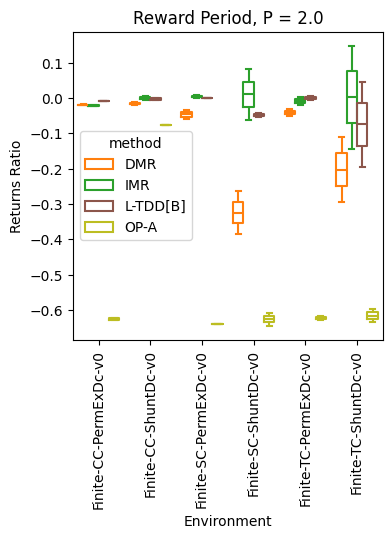

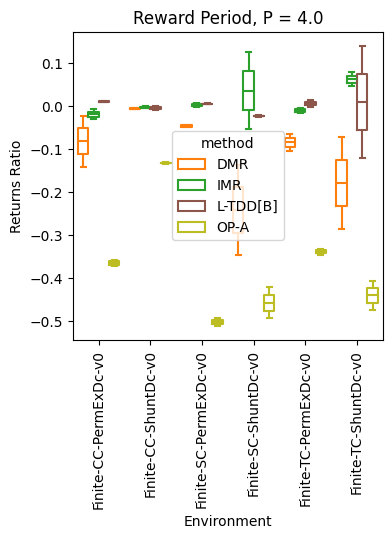

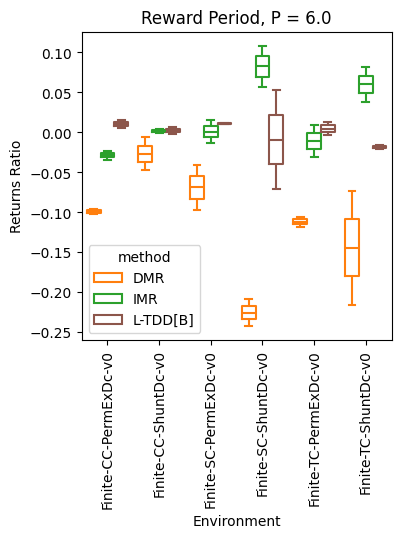

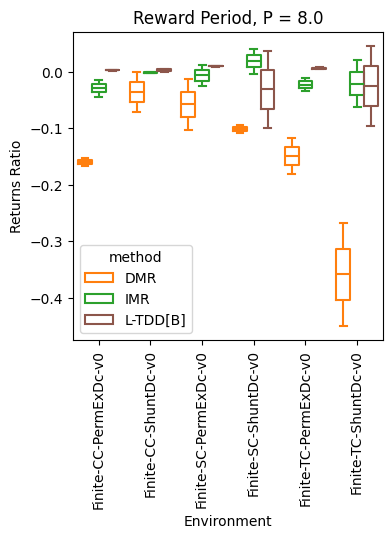

In [57]:
print_regret(
    filter_envs(dfs_regret["sarsa"], 
                envs=set(["Finite-CC-PermExDc-v0", "Finite-CC-ShuntDc-v0", "Finite-SC-PermExDc-v0", "Finite-SC-ShuntDc-v0", "Finite-TC-PermExDc-v0", "Finite-TC-ShuntDc-v0"])),
    suffix="gem_sarsa")

### Regret per Env

In [58]:
def plot_regret_dist(df_data, suffix, output_dir="figures/regret"):
    env_names = sorted(df_data["env_name"].unique())
    for env_name in env_names:
        df_slice = df_data[df_data["env_name"] == env_name]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.kdeplot(
            data=df_slice, 
            x="relative_regret", 
            hue="method", 
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax
        )
        ax.set_xlabel("Returns Ratio")
        ax.set_ylabel("Density")
        ax.set_title(f"Environment = {env_name}")
        name = f"regret_{suffix}_env_{env_name}.pdf"        
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

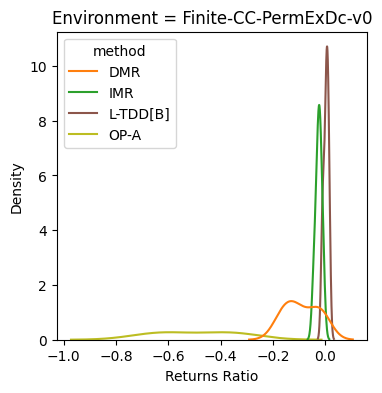

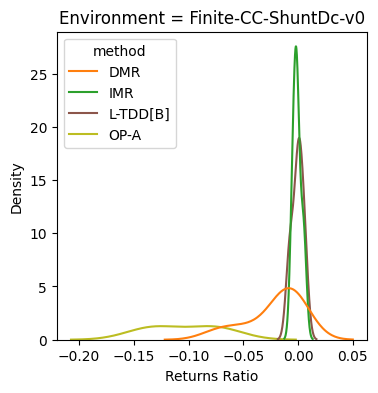

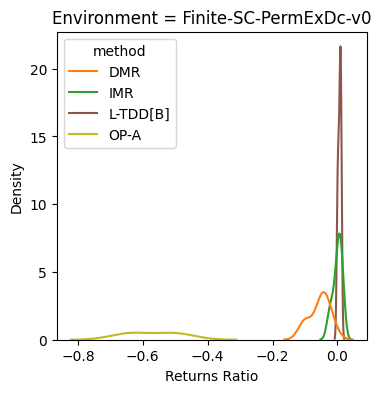

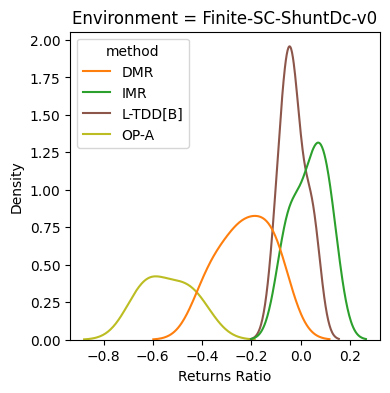

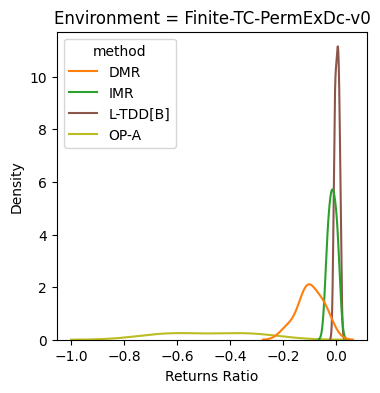

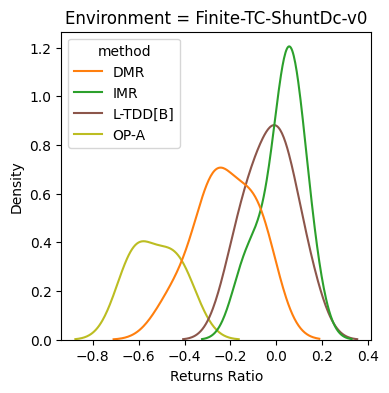

In [59]:
plot_regret_dist(dfs_regret["sarsa"], "sarsa")